In [1]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
import json, os, glob
from PIL import Image, ImageDraw
import numpy as np
from PIL.ImageColor import getrgb

In [3]:
class_dict = {'NFL':13, 'GCL+IPL':5, 'INL':17, 'OPL':2,'ONL':22,'Elipsoid Zone':9,'RPE':3,'Choroid':31}

In [4]:

from keras.utils import normalize
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt
import sys
import random

np.set_printoptions(threshold=sys.maxsize)

In [5]:
import os

# Resizing images
SIZE_X = 640
SIZE_Y = 640
n_classes = 9  # Number of classes for segmentation

# Fixing the paths using raw strings or double backslashes
TRAIN_PATH_X = r"/kaggle/input/xoctlayer"
TRAIN_PATH_Y = r"/kaggle/input/yoctlayer"

# Reading the files in the directories
train_ids_x = next(os.walk(TRAIN_PATH_X))[2]
train_ids_y = next(os.walk(TRAIN_PATH_Y))[2]


In [6]:
#Capture training image info as a list
train_images = []

for directory_path in glob.glob(TRAIN_PATH_X):
    for img_path in glob.glob(os.path.join(directory_path, "*.jpeg")):
        img = cv2.imread(img_path, 0)       
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        train_images.append(img)    

#Convert list to array for machine learning processing        
train_images = np.array(train_images)

In [7]:
#Capture mask/label info as a list
train_masks = [] 
for directory_path in glob.glob(TRAIN_PATH_Y):
    for mask_path in glob.glob(os.path.join(directory_path, "*.jpeg")):
        mask = cv2.imread(mask_path, 0)       
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)  #Otherwise ground truth changes due to interpolation
        train_masks.append(mask)
        
#Convert list to array for machine learning processing          
train_masks = np.array(train_masks)

In [8]:
np.unique(train_masks)

array([  0,  16,  24,  41,  74, 106, 139, 180, 255], dtype=uint8)

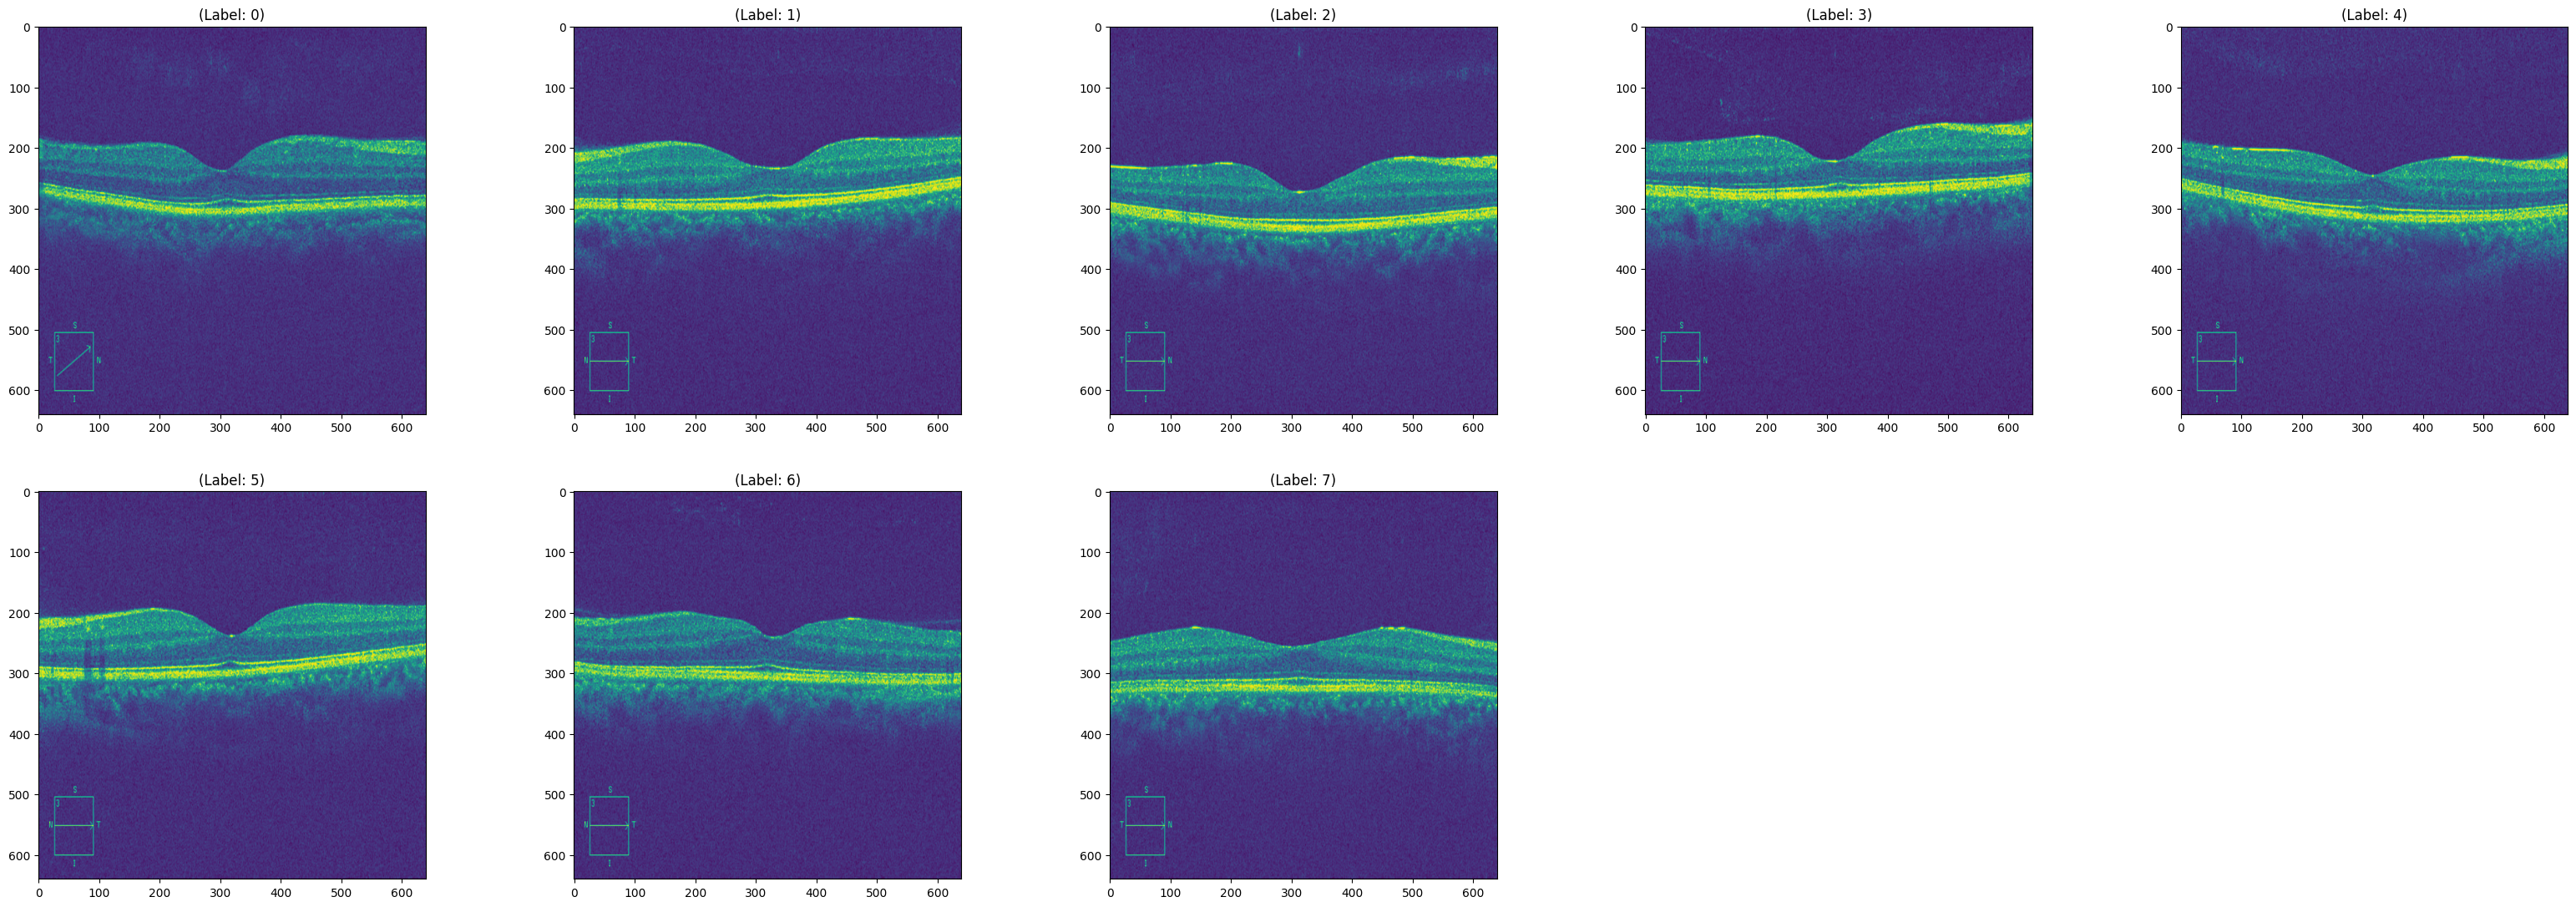

In [9]:
plt.figure(figsize=(40,100))
for i in range(8):
    plt.subplot(14, 5, i+1)
    plt.imshow(train_images[i,:,:])
    plt.title("(Label: " + str(i) + ")")
plt.show()  

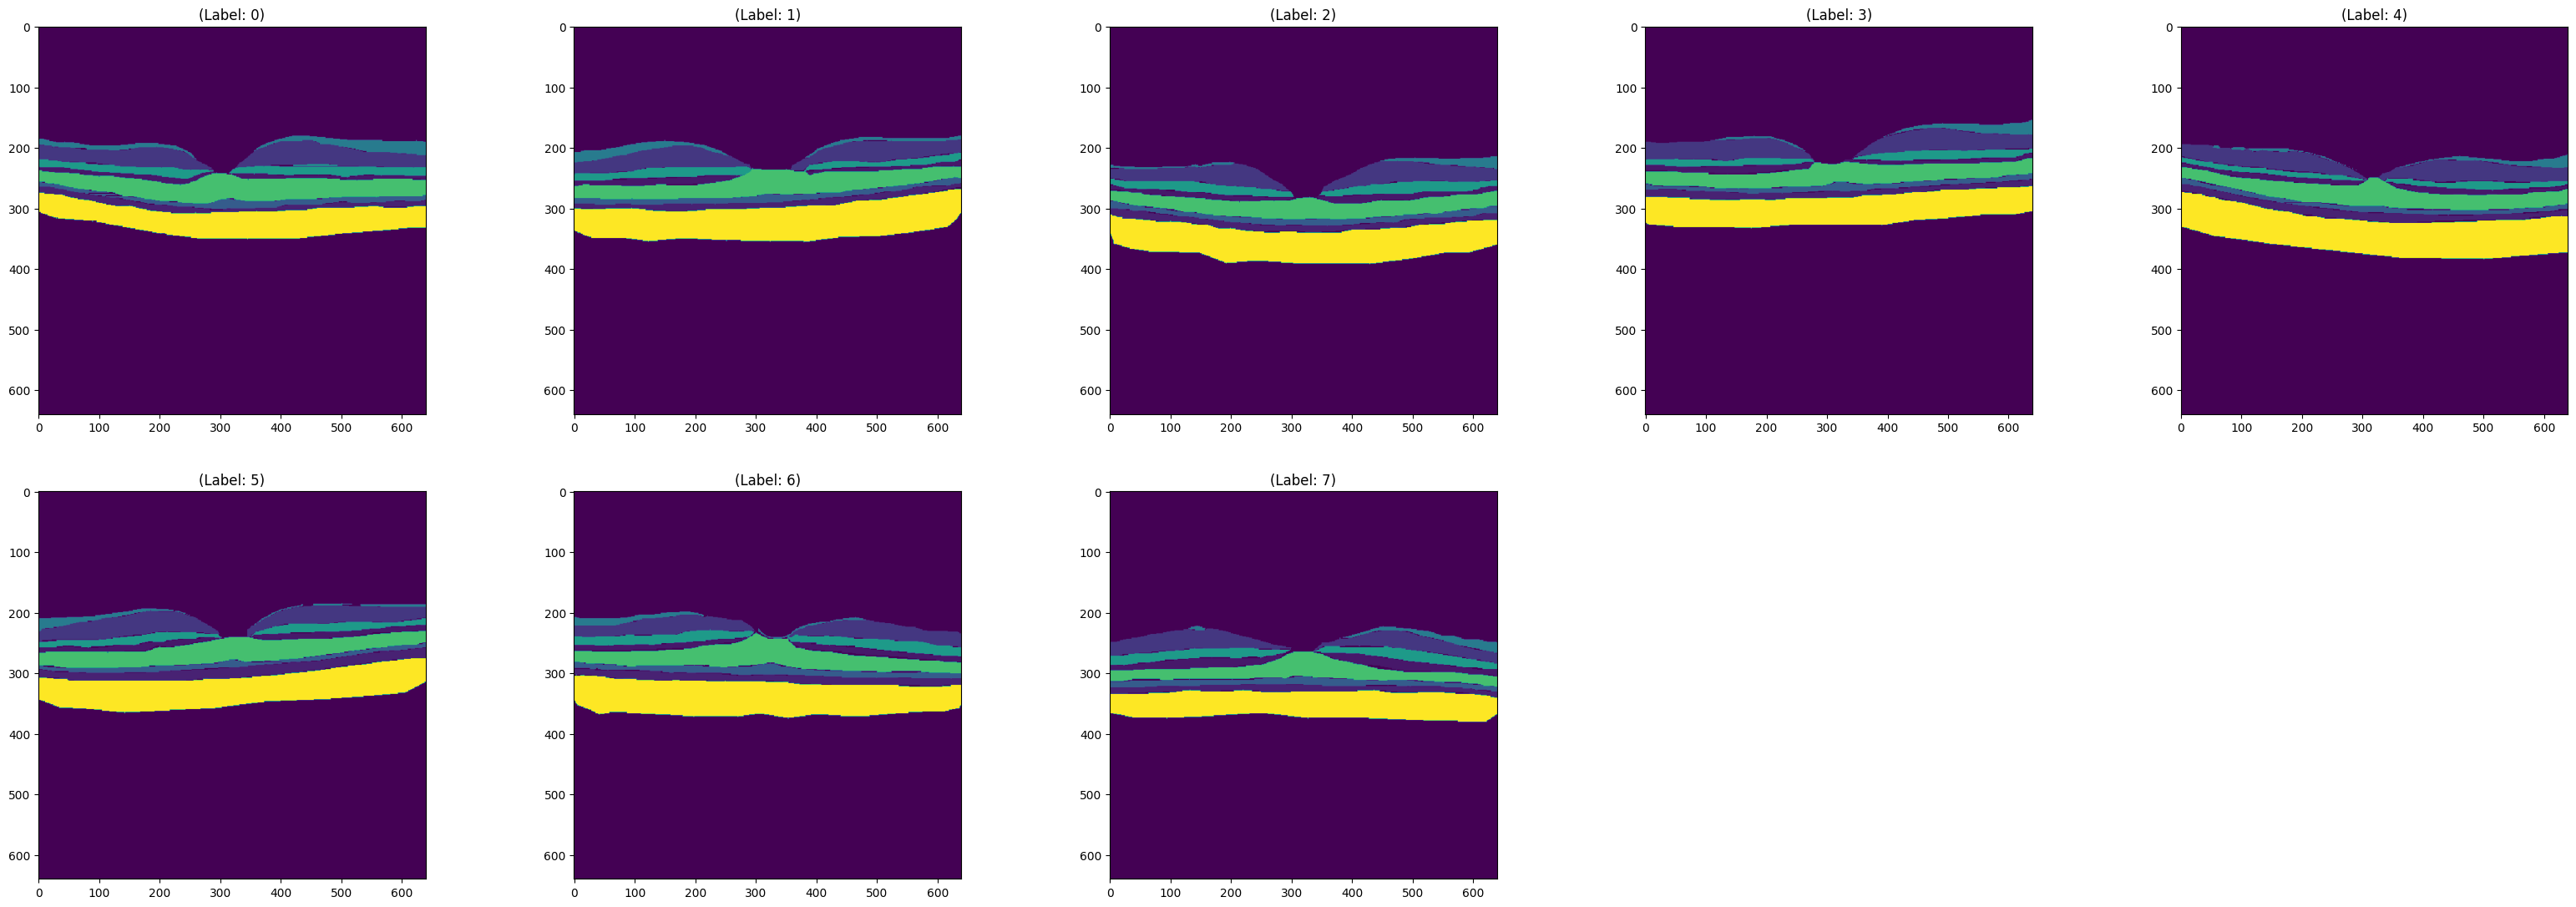

In [10]:
plt.figure(figsize=(40,100))
for i in range(8):
    plt.subplot(14, 5, i+1)
    plt.imshow(train_masks[i,:,:])
    plt.title("(Label: " + str(i) + ")")
plt.show() 

In [11]:
#Encode labels
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

np.unique(train_masks_encoded_original_shape)

train_images = np.expand_dims(train_images, axis=3)
train_images = normalize(train_images, axis=1)

train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [12]:
#Create a subset of data for quick testing
#Picking 10% for testing and remaining for training
from sklearn.model_selection import train_test_split
X1, X_test, y1, y_test = train_test_split(train_images, train_masks_input, test_size = 0.10, random_state = 0)

#Further split training data t a smaller subset for quick testing of models
X_train, X_do_not_use, y_train, y_do_not_use = train_test_split(X1, y1, test_size = 0.2, random_state = 0)

print("Class values in the dataset are ... ", np.unique(y_train)) 

Class values in the dataset are ...  [0 1 2 3 4 5 6 7 8]


In [13]:
from keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))



test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))


IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

In [14]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout

def multi_unet_model(n_classes=9, IMG_HEIGHT=640, IMG_WIDTH=640, IMG_CHANNELS=1):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    
    # Contracting path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)
    
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    # Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
    
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
    
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
    
    # Output layer
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
    
    # Model creation
    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model


In [15]:
model = multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)
model.compile(optimizer= 'adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 640, 640, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 640, 640, 16)   │            160 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 640, 640, 16)   │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 640, 640, 16)   │          2,320 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 320, 320, 16)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 320, 320, 32)   │          4,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 320, 320, 32)   │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 320, 320, 32)   │          9,248 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 160, 160, 32)   │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 160, 160, 64)   │         18,496 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 160, 160, 64)   │              0 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 160, 160, 64)   │         36,928 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 80, 80, 64)     │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 80, 80, 128)    │         73,856 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 80, 80, 128)    │              0 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 80, 80, 128)    │        147,584 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 40, 40, 128)    │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)    

 Total params: 1,940,953 (7.40 MB)

 Trainable params: 1,940,953 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
#If starting with pre-trained weights. 
#model.load_weights('???.hdf5')

history = model.fit(X_train, y_train_cat, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=200, 
                    validation_data=(X_test, y_test_cat), 
                    #class_weight=class_weights,
                    shuffle=False)
                    

_, acc = model.evaluate(X_test, y_test_cat)
print("Accuracy is = ", (acc * 100.0), "%")

Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 35s 35s/step - accuracy: 0.0381 - loss: 2.2027 - val_accuracy: 0.3355 - val_loss: 2.1891
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.2685 - loss: 2.1837 - val_accuracy: 0.4277 - val_loss: 2.1274
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - accuracy: 0.3456 - loss: 2.0903 - val_accuracy: 0.5539 - val_loss: 1.9672
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.4744 - loss: 2.9717 - val_accuracy: 0.7424 - val_loss: 2.0380
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.5842 - loss: 1.9512 - val_accuracy: 0.7754 - val_loss: 2.1116
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.6956 - loss: 2.0604 - val_accuracy: 0.7765 - val_loss: 2.1229
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - accuracy: 0.7536 - loss: 2.0971 - val_accuracy: 0.7766 - val_loss: 2.1176
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - accuracy: 0.7705 - loss: 2.1002 - val_accuracy: 0.7767 - va

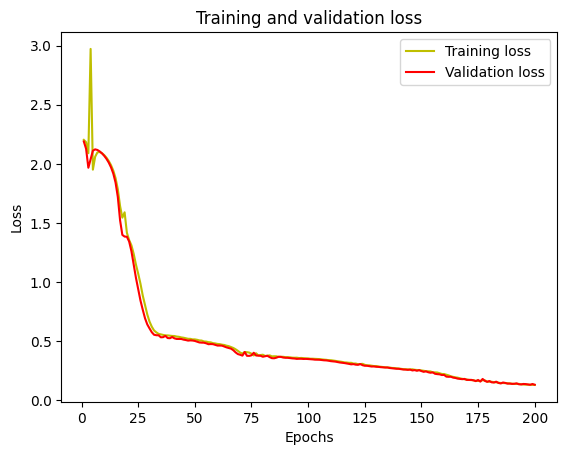

In [17]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

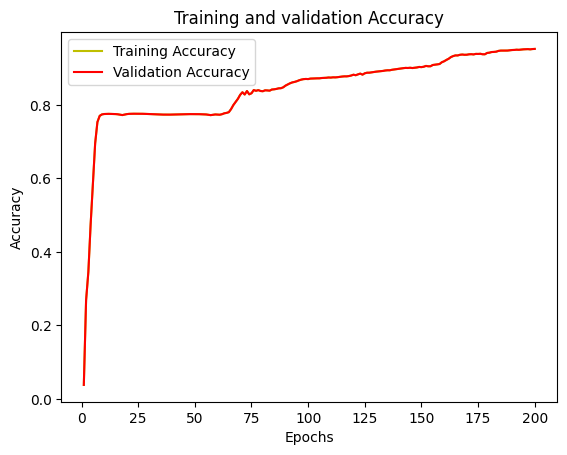

In [18]:
acc = history.history['accuracy']
val_acc = history.history['accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [19]:
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step


In [20]:
#Using built in keras function
from keras.metrics import MeanIoU
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.60279566


In [22]:
## This is example of IOU of 4 class, if you need provide corresponding amount of class 

values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])


print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
print("IoU for class4 is: ", class4_IoU)

plt.imshow(train_images[0, :,:,0], cmap='gray')
plt.imshow(train_masks[0], cmap='gray')

AttributeError: 'MeanIoU' object has no attribute 'get_weights'

In [23]:
model.save('retina_segmentation_8_layer_iter_3+20epochs.hdf5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


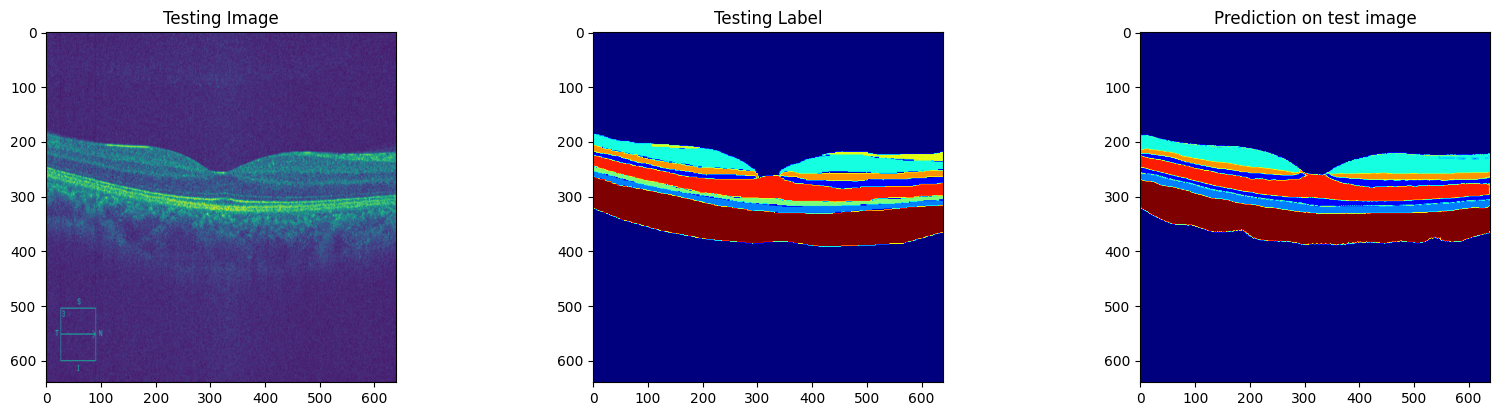

In [24]:
test_img_number = 5
test_img = X_train[test_img_number]
ground_truth= y_train[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)

prediction = (model.predict(test_img_input))
predicted_img = np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(20, 10))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0])
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.show()

In [25]:
#Capture training image info as a list
test_test = []

test_path = "/home/khamituly/Documents/Diploma work/big_datasets/manual_segm/"

for directory_path in glob.glob(test_path):
    for img_path in glob.glob(os.path.join(directory_path, "*.jpeg")):
        img = cv2.imread(img_path, 0)       
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        test_test.append(img)
        print(img_path)    

#Convert list to array for machine learning processing        
test_test = np.array(test_test)

test_test = np.expand_dims(test_test, axis=3)
test_test = normalize(test_test, axis=1)

AxisError: axis 3 is out of bounds for array of dimension 2

In [26]:
test_test.shape

(0,)

In [27]:
test1 = test_test[12]
test_img_norm=test1[:,:,0][:,:,None]
test=np.expand_dims(test_img_norm, 0)

prediction = (model.predict(test))
predicted_img = np.argmax(prediction, axis=3)[0,:,:]

plt.figure(figsize=(40, 20))

plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test1[:,:,0])

plt.subplot(232)
plt.title('Prediction<')
# plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.imshow(predicted_img, cmap='jet')

# plt.imshow(prediction[0,:,:,7], cmap='jet')

IndexError: index 12 is out of bounds for axis 0 with size 0

In [28]:
prediction.shape

(1, 640, 640, 9)

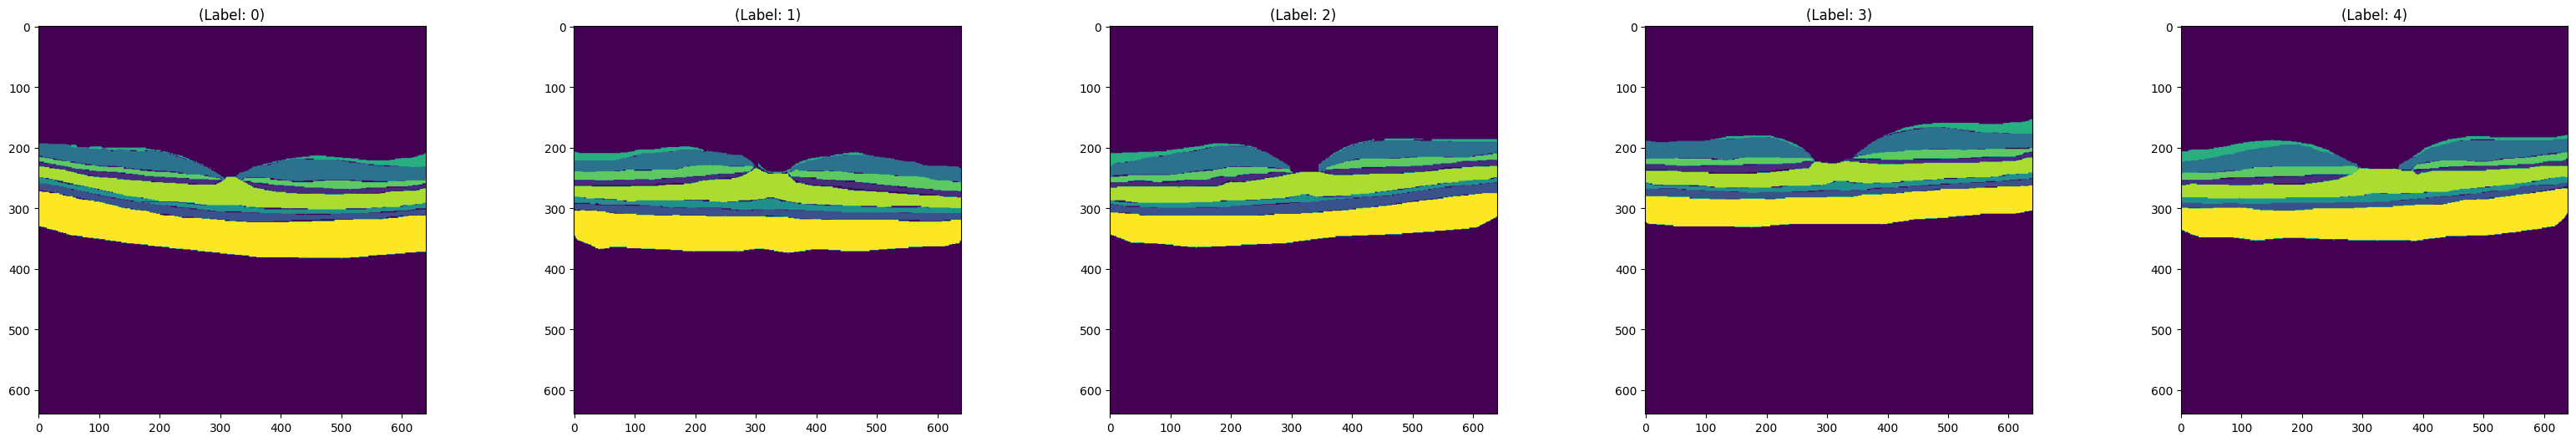

In [29]:
plt.figure(figsize=(40,100))
# print("Оригинал изображений")
for i in range(5):
    plt.subplot(14, 5, i+1)
    plt.imshow(y_train[i,:,:])
    # curr_lbl = X_test[i]
    plt.title("(Label: " + str(i) + ")")
plt.show()  

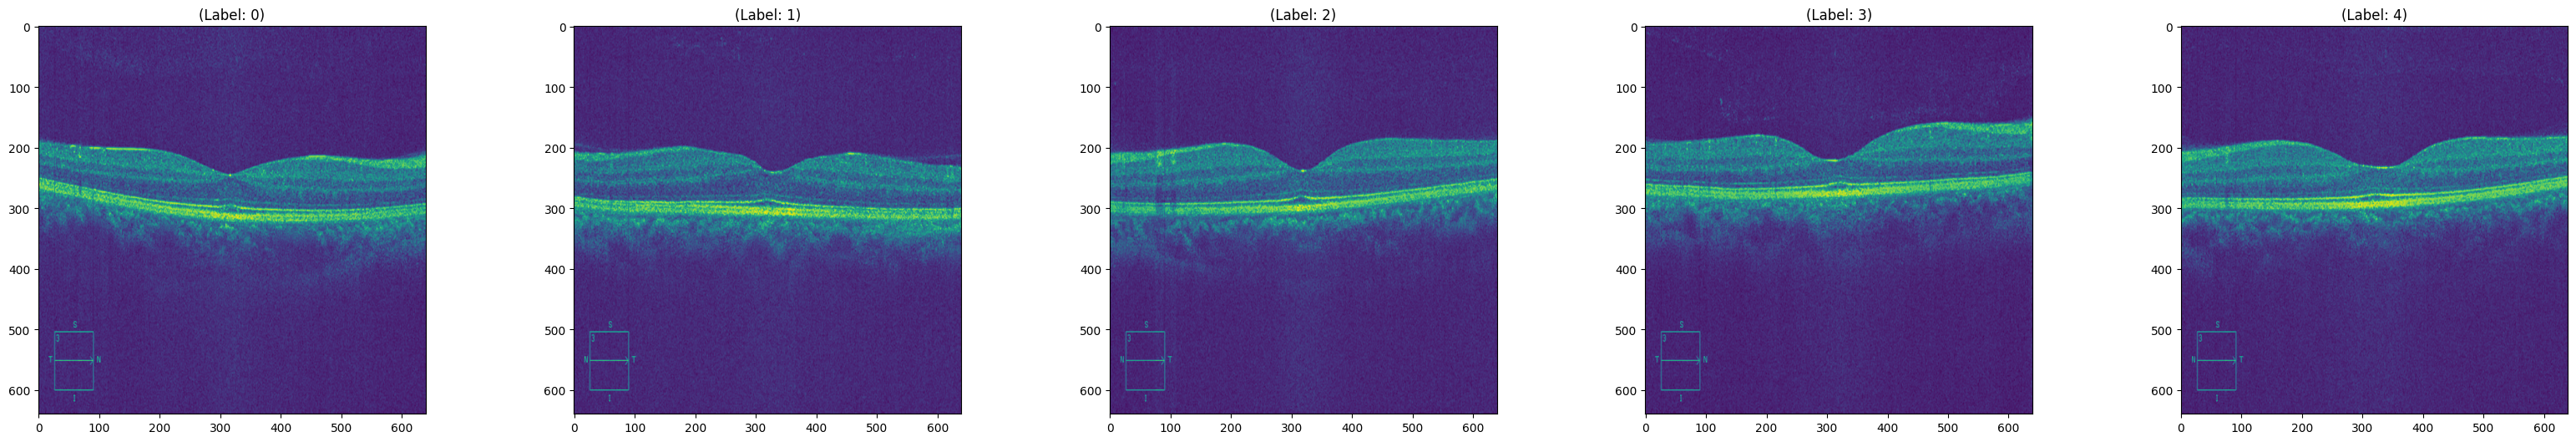

In [30]:
plt.figure(figsize=(40,100))
# print("Оригинал изображений")
for i in range(5):
    plt.subplot(14, 5, i+1)
    plt.imshow(X_train[i,:,:])
    # curr_lbl = X_test[i]
    plt.title("(Label: " + str(i) + ")")
plt.show() 

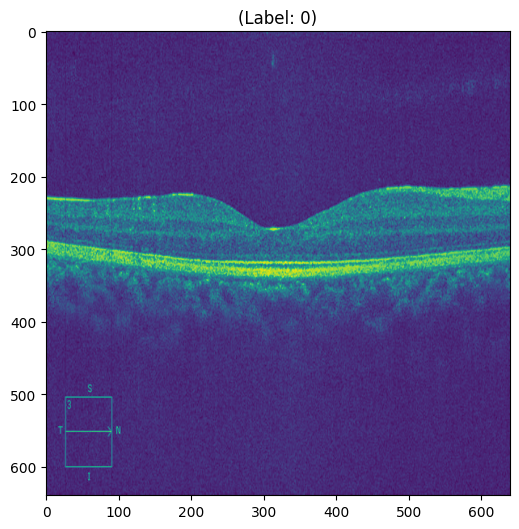

In [31]:
	
plt.figure(figsize=(40,100))
# print("Оригинал изображений")
for i in range(1):
    plt.subplot(14, 5, i+1)
    plt.imshow(X_test[i,:,:])
    # curr_lbl = X_test[i]
    plt.title("(Label: " + str(i) + ")")
plt.show()  

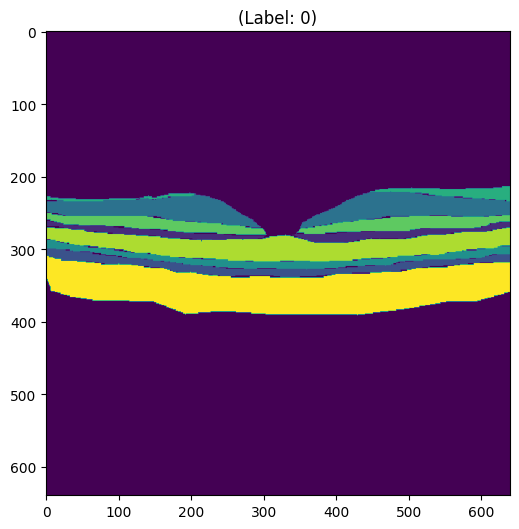

In [32]:
plt.figure(figsize=(40,100))
# print("Оригинал изображений")
for i in range(1):
    plt.subplot(14, 5, i+1)
    plt.imshow(y_test[i,:,:])
    # curr_lbl = X_test[i]
    plt.title("(Label: " + str(i) + ")")
plt.show() 

In [33]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import numpy as np


# Predict classes and probabilities
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Calculate metrics
#accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Print metrics
print(f"Accuracy: {accuracy * 100.0:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


ValueError: unknown is not supported

In [34]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
#If starting with pre-trained weights. 
#model.load_weights('???.hdf5')

history = model.fit(X_train, y_train_cat, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=10, 
                    validation_data=(X_test, y_test_cat), 
                    #class_weight=class_weights,
                    shuffle=False)
                    

_, acc = model.evaluate(X_test, y_test_cat)
print("Accuracy is = ", (acc * 100.0), "%")
# Ensure `y_true` and `y_pred` are correctly formatted
y_true = np.argmax(y_test_cat, axis=1)  # Convert one-hot to class indices
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class indices

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

# Print metrics
print(f"Accuracy: {accuracy * 100.0:.2f}%")
print(f"Precision: {precision * 100.0:.2f}%")
print(f"Recall: {recall * 100.0:.2f}%")
print(f"F1-Score: {f1 * 100.0:.2f}%")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, zero_division=0))


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - accuracy: 0.9521 - loss: 0.1322 - val_accuracy: 0.9533 - val_loss: 0.1305
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.9520 - loss: 0.1310 - val_accuracy: 0.9547 - val_loss: 0.1334
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.9537 - loss: 0.1288 - val_accuracy: 0.9544 - val_loss: 0.1333
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.9544 - loss: 0.1274 - val_accuracy: 0.9531 - val_loss: 0.1312
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.9528 - loss: 0.1280 - val_accuracy: 0.9551 - val_loss: 0.1289
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.9535 - loss: 0.1274 - val_accuracy: 0.9539 - val_loss: 0.1335
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.9551 - loss: 0.1243 - val_accuracy: 0.9529 - val_loss: 0.1352
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.9543 - loss: 0.1276 - val_accuracy: 0.9567 - val_loss:

ValueError: unknown is not supported